## Read depth model
Modeled as zero inflated negative binomial distribution

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.stats import betabinom
import numpy as np
from scipy.special import logsumexp
from collections import Counter

In [3]:
sample = "mm34"

reference = pd.read_csv(rf'../data/input_data/{sample}/ref.csv', index_col=0)
alternative = pd.read_csv(rf'../data/input_data/{sample}/alt.csv', index_col=0)
coverage = reference.fillna(0) + alternative.fillna(0)
vaf = alternative/(alternative+reference).fillna(0)

In [4]:
def sample_zinb(mu, theta, pi, size):
    """
    Samples synthetic data from the learned ZINB distribution.
    
    Args:
        mu: Mean of the Negative Binomial.
        theta: Dispersion parameter of the Negative Binomial.
        pi: Zero-inflation probability.
        size: Number of samples to generate.
    
    Returns:
        A numpy array of sampled data.
    """
    nb_samples = nbinom.rvs(theta, theta / (theta+ mu), size=size)
    zero_inflation_mask = np.random.rand(size) < pi
    samples = np.where(zero_inflation_mask, 0, nb_samples)
    return samples

# learned from mm34 scRNA seq dataset
mu, theta, pi = 60, 0.17, 0.38
synthetic_data = sample_zinb(mu, theta, pi, size=10000)

We have to deal with a very large proportion of zero read depths

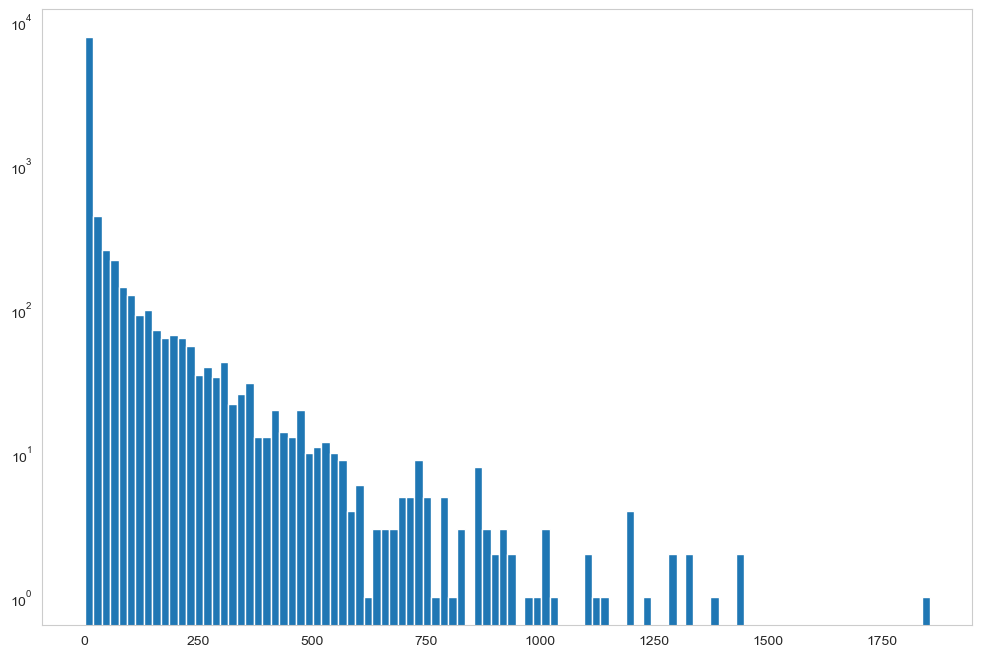

In [5]:
plt.figure(figsize=(12, 8))
plt.hist(synthetic_data, bins=100)
plt.yscale('log')
plt.grid(False)
plt.show()

## VAF simulation

1. Homozygous alternative genotype
2. Homozygous reference genotype
3. Heterozygous genotype

1. Homozygous reference genotype

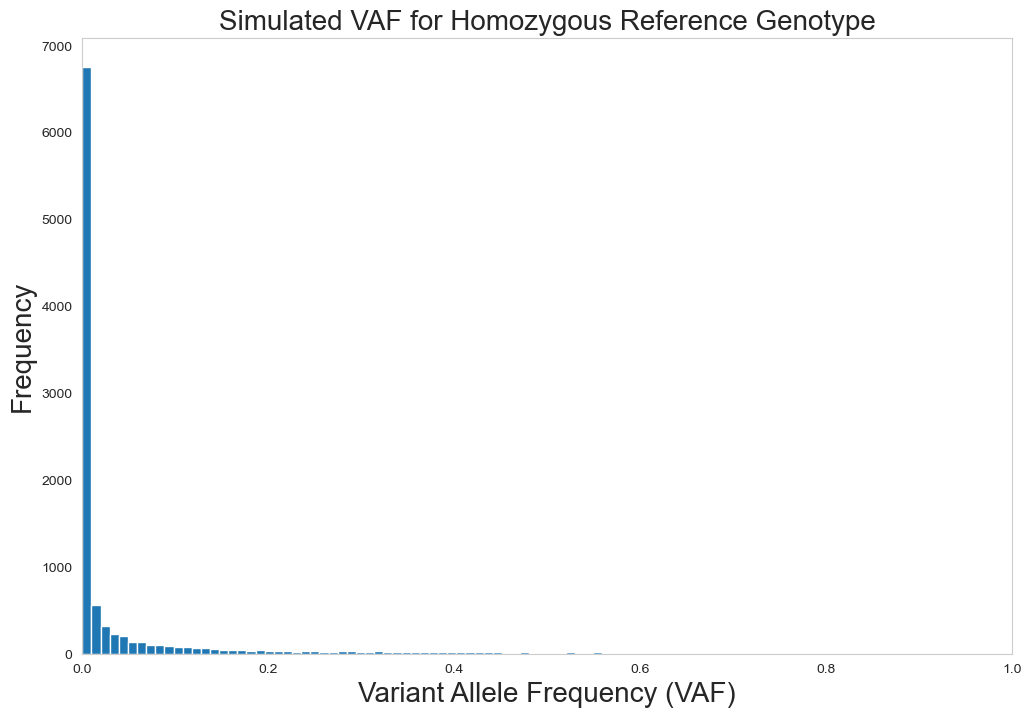

In [6]:
N = 1000  # Read depth
overdispersion = 2 # Should be learned
error_rate = 0.05  # Sequencing error rate (learned?)
alpha = error_rate * overdispersion
beta = overdispersion - alpha

# Generate simulated data for VAF using Beta-Binomial
simulated_vaf = betabinom.rvs(N, alpha, beta, size=10000) / N  # Scale by N to get VAFs

plt.figure(figsize=(12, 8))
plt.hist(simulated_vaf, bins=100)
plt.title("Simulated VAF for Homozygous Reference Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xlim([0, 1])
plt.grid(False)
plt.show()

2. Homozygous alternative genotype

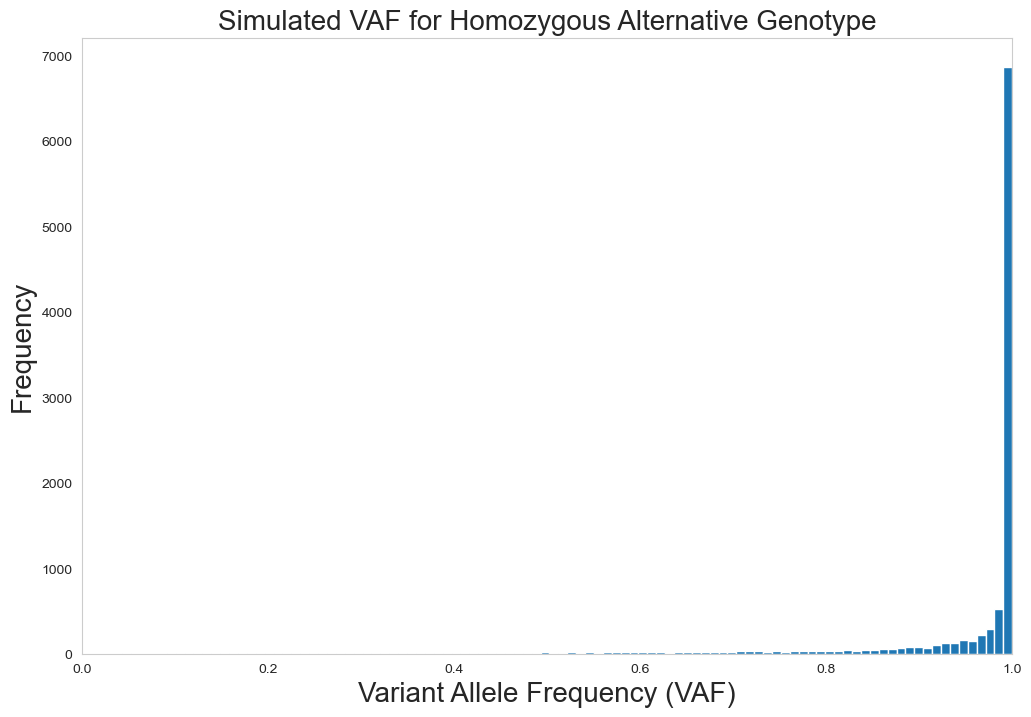

In [7]:
N = 1000  # Read depth
overdispersion = 2 # Should be learned
error_rate = 0.05  # Sequencing error rate (learned?)
alpha = (1-error_rate) * overdispersion
beta = overdispersion - alpha

# Generate simulated data for VAF using Beta-Binomial
simulated_vaf = betabinom.rvs(N, alpha, beta, size=10000) / N  # Scale by N to get VAFs

plt.figure(figsize=(12, 8))
plt.hist(simulated_vaf, bins=100)
plt.title("Simulated VAF for Homozygous Alternative Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xlim([0, 1])
plt.grid(False)
plt.show()

3. Heterozygous genotype

Technical dropout

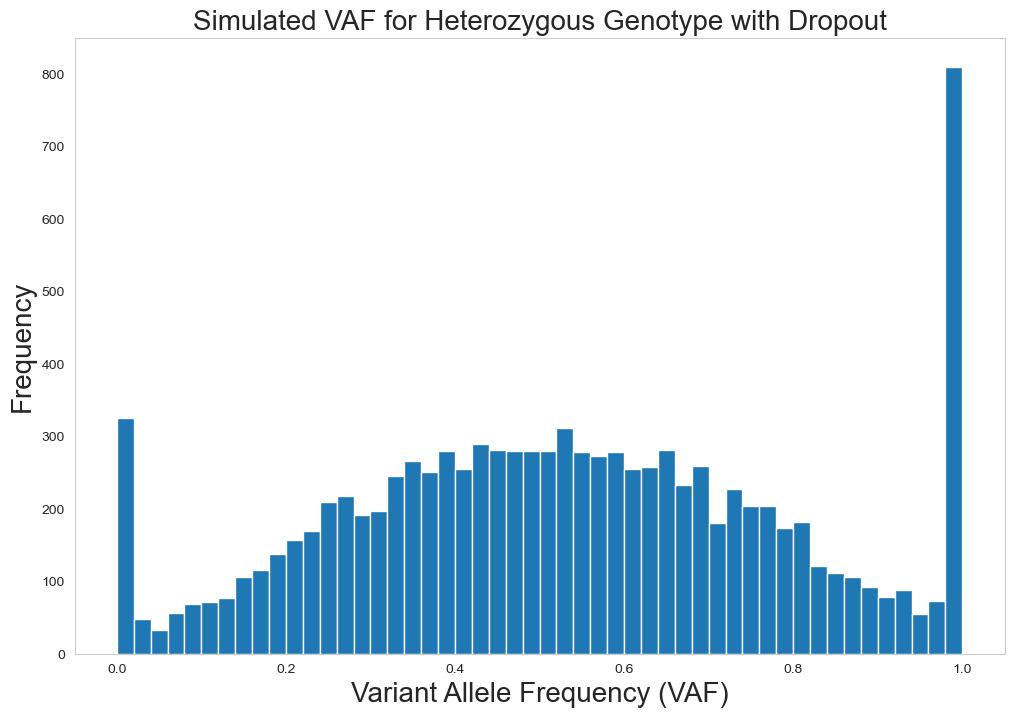

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import betabinom, bernoulli

def simulate_vaf_counts(alpha, beta, dropout_prob, dropout_direction_prob, N, num_simulations, error_rate, overdispersion, dropout_alpha=2, dropout_beta=8, dropout_dir_alpha=4, dropout_dir_beta=4):
    """
    Simulates VAF counts for a heterozygous genotype considering dropout and overdispersion.
    
    Parameters:
    - alpha: Shape parameter of the Beta distribution.
    - beta: Shape parameter of the Beta distribution.
    - dropout_prob: Probability of a technical dropout.
    - dropout_direction_prob: Probability the dropout favors the reference allele.
    - N: Read depth
    - num_simulations: Number of VAF simulations.
    - error_rate: Error rate for monoallelic expressed genes
    - overdispersion: Overdispersion parameter for monoallelic expressed genes
    
    
    Returns:
    - vaf_counts: Array of simulated VAF counts (variant reads).
    """
    vaf_counts = []
    
    for _ in range(num_simulations):
        # Check if a dropout occurs
        
        # dropout_prob = np.random.beta(dropout_alpha, dropout_beta) # samples the dropout rate
        # dropout_direction = np.random.beta(dropout_dir_alpha, dropout_dir_beta) # samples how imbalanced the dropout is between the alleles

        # Determine if dropout occurs
        dropout_occurs = np.random.rand() < dropout_prob

        if dropout_occurs:
            # Determine dropout direction based on sampled probabilities
            dropout_to_A = np.random.rand() < dropout_direction_prob
        
            if dropout_to_A:
                alpha_seq = (1-error_rate) * overdispersion
                beta_seq = overdispersion - alpha_seq
                alt_reads = betabinom.rvs(N, alpha_seq, beta_seq)
                # alt_reads = 0
            else:
                alpha_seq = (error_rate) * overdispersion
                beta_seq = overdispersion - alpha_seq
                alt_reads = betabinom.rvs(N, alpha_seq, beta_seq)
                # alt_reads = N
        
        else:
            # No dropout: use Beta-Binomial distribution to simulate alt reads
            alt_reads = betabinom.rvs(N, alpha, beta)
        
        vaf_counts.append(alt_reads) 
         
    vaf_counts = np.array(vaf_counts)/N
    
    return vaf_counts

# Parameters
alpha = 2.5               # Beta distribution alpha parameter
beta = 2.5               # Beta distribution beta parameter
dropout_prob = 0.15      # Probability of a technical dropout
dropout_direction_prob = 0.7  # Probability dropout favors reference allele
error_rate = 0.05       # Sequencing error rate
overdispersion = 2      # Overdispersion of sequencing errors.
N = 300                 # Read depth
num_simulations = 10000 # Number of simulations

# Simulate VAF counts
vaf_counts = simulate_vaf_counts(alpha, beta, dropout_prob, dropout_direction_prob, N, num_simulations, error_rate, overdispersion)

plt.figure(figsize=(12, 8))
plt.hist(vaf_counts, bins=50)
plt.title("Simulated VAF for Heterozygous Genotype with Dropout",  fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.grid(False)

plt.show()

Ground Truth Parameters:
f_AA: 0.6000, f_Aa: 0.3000, f_aa: 0.1000
Simulated Read Counts: Counter({'AA': 599, 'Aa': 305, 'aa': 96})

Estimated Parameters:
f_AA: 0.6008, f_Aa: 0.3044, f_aa: 0.0948
Observed Read Counts: Counter({0: 562, 1: 356, 2: 82})


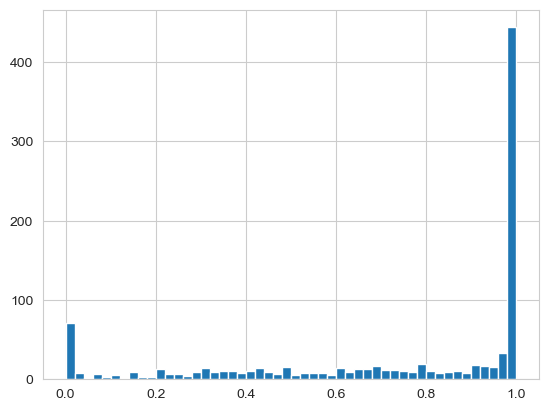

In [9]:
def beta_binomial_params(overdispersion, error_rate, genotype):
    """
    Computes the Beta-Binomial parameters for a given genotype.
    """
    if genotype == "AA":  # Homozygous reference
        alpha = (1 - error_rate) * overdispersion
        beta = overdispersion - alpha
    elif genotype == "aa":  # Homozygous alternative
        alpha = error_rate * overdispersion
        beta = overdispersion - alpha
    return alpha, beta

def genotype_probability(k, N, overdispersion, error_rate, genotype, alpha_h, beta_h):
    """
    Computes the probability of observing `k` alternative reads given genotype.
    """
    if genotype == "Aa":
        alpha, beta = alpha_h, beta_h
    else:
        alpha, beta = beta_binomial_params(overdispersion, error_rate, genotype)
    return betabinom.pmf(k, N, alpha, beta)

def e_step(k_obs, N, f_AA, f_Aa, f_aa, overdispersion, error_rate, alpha_h, beta_h):
    """
    E-Step: Computes the responsibilities for each genotype given observations.
    """
    responsibilities = []
    for k, n in zip(k_obs, N):
        # Compute unnormalized posterior probabilities for each genotype
        log_p_AA = np.log(f_AA) + np.log(genotype_probability(k, n, overdispersion, error_rate, "AA", alpha_h, beta_h))
        log_p_Aa = np.log(f_Aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "Aa", alpha_h, beta_h))
        log_p_aa = np.log(f_aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "aa", alpha_h, beta_h))
        
        # Use log-sum-exp trick for numerical stability
        log_total = logsumexp([log_p_AA, log_p_Aa, log_p_aa])
        
        # Compute responsibilities
        resp_AA = np.exp(log_p_AA - log_total)
        resp_Aa = np.exp(log_p_Aa - log_total)
        resp_aa = np.exp(log_p_aa - log_total)
        
        responsibilities.append([resp_AA, resp_Aa, resp_aa])
    
    return np.array(responsibilities)

def m_step(responsibilities):
    """
    M-Step: Updates genotype frequencies based on responsibilities.
    """
    f_AA = np.mean(responsibilities[:, 0])
    f_Aa = np.mean(responsibilities[:, 1])
    f_aa = np.mean(responsibilities[:, 2])
    return f_AA, f_Aa, f_aa

def em_algorithm_fixed_params(k_obs, N, f_AA_init, f_Aa_init, f_aa_init, overdispersion, error_rate, alpha_h, beta_h, min_iterations=10, max_iterations=100, tolerance=1e-6):
    """
    Runs the EM algorithm to estimate genotype proportions with fixed parameters.
    """
    f_AA, f_Aa, f_aa = f_AA_init, f_Aa_init, f_aa_init
    prev_log_likelihood = None
    
    for iteration in range(max_iterations):
        # E-Step
        responsibilities = e_step(k_obs, N, f_AA, f_Aa, f_aa, overdispersion, error_rate, alpha_h, beta_h)
        
        # M-Step
        f_AA, f_Aa, f_aa = m_step(responsibilities)
        
        # Compute log-likelihood for convergence check
        log_likelihood = 0
        for k, n, resp in zip(k_obs, N, responsibilities):
            log_p_AA = np.log(f_AA) + np.log(genotype_probability(k, n, overdispersion, error_rate, "AA", alpha_h, beta_h))
            log_p_Aa = np.log(f_Aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "Aa", alpha_h, beta_h))
            log_p_aa = np.log(f_aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "aa", alpha_h, beta_h))
            log_total = logsumexp([log_p_AA, log_p_Aa, log_p_aa])
            log_likelihood += log_total
        
        # Check convergence
        if iteration >= min_iterations:  # Only check convergence after min_iterations
            if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < tolerance:
                break
        
        prev_log_likelihood = log_likelihood
    
    return f_AA, f_Aa, f_aa, responsibilities

# Parameters
np.random.seed(42)
num_simulations = 1000
overdispersion = 2
error_rate = 0.05
alpha_h, beta_h = 2, 2  # Heterozygous Beta-Binomial parameters
f_AA_true, f_Aa_true, f_aa_true = 0.6, 0.3, 0.1

# Simulate varying read depths
N = np.random.randint(500, 1500, size=num_simulations)  # Variable read depths

# Generate simulated data
genotypes = np.random.choice(["AA", "Aa", "aa"], size=num_simulations, p=[f_AA_true, f_Aa_true, f_aa_true])
k_obs = []
read_counts = Counter(genotypes)
for genotype, n in zip(genotypes, N):
    if genotype == "Aa":
        alpha, beta = alpha_h, beta_h
    else:
        alpha, beta = beta_binomial_params(overdispersion, error_rate, genotype)
    k_obs.append(betabinom.rvs(n, alpha, beta))

# Run EM algorithm with fixed parameters
f_AA_init, f_Aa_init, f_aa_init = 1/3, 1/3, 1/3
f_AA_est, f_Aa_est, f_aa_est, responsibilities = em_algorithm_fixed_params(
    k_obs, N, f_AA_init, f_Aa_init, f_aa_init, overdispersion, error_rate, alpha_h, beta_h
)

# Observed read counts
observed_counts = Counter(np.argmax(responsibilities, axis=1))
total_simulations = sum(observed_counts.values())

# Results
print("Ground Truth Parameters:")
print(f"f_AA: {f_AA_true:.4f}, f_Aa: {f_Aa_true:.4f}, f_aa: {f_aa_true:.4f}")
print(f"Simulated Read Counts: {read_counts}")
print("\nEstimated Parameters:")
print(f"f_AA: {f_AA_est:.4f}, f_Aa: {f_Aa_est:.4f}, f_aa: {f_aa_est:.4f}")
print(f"Observed Read Counts: {observed_counts}")

plt.hist(k_obs/N, bins=50)
plt.show()

f_AA: 0.5084, f_Aa: 0.1861, f_aa: 0.3055


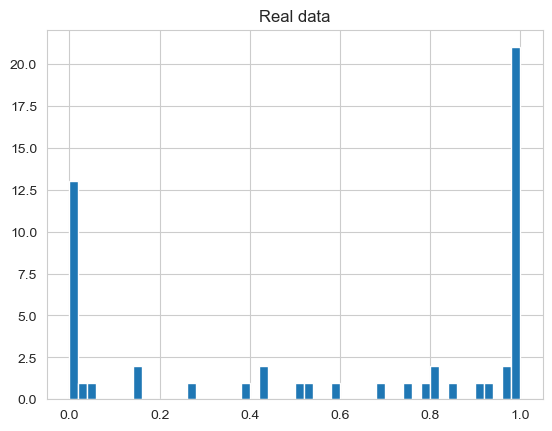

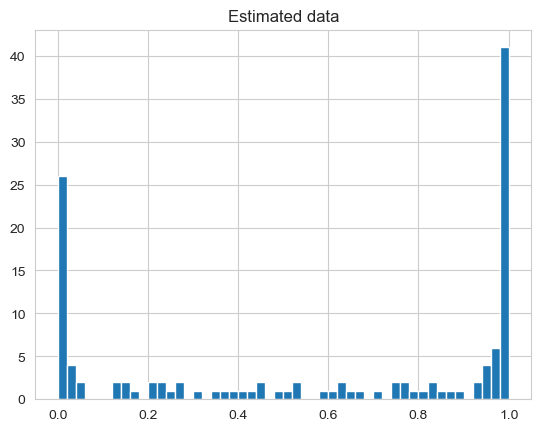

In [10]:
f_AA_init, f_Aa_init, f_aa_init = 1/3, 1/3, 1/3

non_zero_indices = np.where(coverage.iloc[:, 0] > 0)[0]
N_nonzero = np.array(coverage)[:, 0][non_zero_indices]
k_obs_nonzero = np.array(alternative)[:, 0][non_zero_indices]

f_AA_est, f_Aa_est, f_aa_est, responsibilities = em_algorithm_fixed_params(
    k_obs_nonzero, N_nonzero, f_AA_init, f_Aa_init, f_aa_init, overdispersion, error_rate, alpha_h, beta_h
)
print(f"f_AA: {f_AA_est:.4f}, f_Aa: {f_Aa_est:.4f}, f_aa: {f_aa_est:.4f}")

n_cells = 127
N = np.random.randint(500, 1500, size=n_cells)  # Variable read depths

# Generate simulated data
genotypes = np.random.choice(["AA", "Aa", "aa"], size=n_cells, p=[f_AA_est, f_Aa_est, f_aa_est])
k_obs = []
read_counts = Counter(genotypes)
for genotype, n in zip(genotypes, N):
    if genotype == "Aa":
        alpha, beta = alpha_h, beta_h
    else:
        alpha, beta = beta_binomial_params(overdispersion, error_rate, genotype)
    k_obs.append(betabinom.rvs(n, alpha, beta))
    
plt.hist(vaf.iloc[:, 0], bins=50)
plt.title("Real data")
plt.show()

plt.hist(k_obs/N, bins=50)
plt.title("Estimated data")
plt.show()

In [11]:
import numpy as np
from scipy.special import gammaln, logsumexp
from scipy.optimize import minimize_scalar

# Log likelihood for Beta-Binomial
def beta_binomial_log_likelihood(k, n, alpha, beta):
    """
    Computes the log-likelihood for a single Beta-Binomial observation.
    """
    log_coeff = gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1)
    log_beta = gammaln(alpha + k) + gammaln(beta + n - k) - gammaln(alpha + beta + n)
    log_beta_norm = gammaln(alpha) + gammaln(beta) - gammaln(alpha + beta)
    return log_coeff + log_beta - log_beta_norm

In [13]:
np.random.seed(42)

# Log likelihood for all observations
def total_log_likelihood(params, k_obs, N_obs, genotypes):
    """
    Computes the total log-likelihood for the given parameters and observations.
    """
    dropout_prob, dropout_direction_prob, overdispersion, error_rate, alpha_h, beta_h = params
    log_likelihood = 0
    num_obs = len(k_obs)
    log_likelihoods_R = []

    for k, n, genotype in zip(k_obs, N_obs, genotypes):
        if genotype == "R":
            # Homozygous dominant: no dropout
            alpha = error_rate * overdispersion
            beta = overdispersion - alpha
            log_likelihood += beta_binomial_log_likelihood(k, n, alpha, beta)
            log_likelihoods_R.append(beta_binomial_log_likelihood(k, n, alpha, beta))

        elif genotype == "H":
            # Heterozygous: apply dropout
        
            # No dropout likelihood
            log_no_dropout = np.log(1 - dropout_prob) + beta_binomial_log_likelihood(k, n, alpha_h, beta_h)
        
            # Dropout to "AA"
            alpha_AA = error_rate * overdispersion
            beta_AA = overdispersion - alpha_AA
            log_dropout_AA = np.log(dropout_prob) + np.log(1 - dropout_direction_prob) + \
                beta_binomial_log_likelihood(k, n, alpha_AA, beta_AA)
        
            # Dropout to "aa"
            alpha_aa = (1-error_rate) * overdispersion
            beta_aa = overdispersion - alpha_aa
            log_dropout_aa = np.log(dropout_prob) + np.log(dropout_direction_prob) + \
                beta_binomial_log_likelihood(k, n, alpha_aa, beta_aa)
        
            # Combine probabilities
            log_likelihood += logsumexp([log_no_dropout, log_dropout_AA, log_dropout_aa])
            
        elif genotype == "A":
            # Homozygous recessive: no dropout
            alpha = (1-error_rate) * overdispersion
            beta = overdispersion - alpha
            log_likelihood += beta_binomial_log_likelihood(k, n, alpha, beta)

        else:
            raise ValueError(f"Unexpected genotype: {genotype}")

    return -log_likelihood/num_obs


def fit_parameters_coord_descent_damped(k_obs, N_obs, genotypes, 
                                        initial_params=None, 
                                        max_iterations=1000, 
                                        tolerance=1e-5, 
                                        damping_factor=0.5):
    """
    Fit dropout probability, dropout direction probability, overdispersion, error rate,
    and heterozygous-specific alpha and beta using coordinate descent with damping.
    """
    def optimize_param(param_idx, params, k_obs, N_obs, genotypes):
        """Optimize a single parameter while keeping others fixed."""
        def objective(param_value):
            new_params = params.copy()
            new_params[param_idx] = param_value
            return total_log_likelihood(new_params, k_obs, N_obs, genotypes)
        
        bounds = [
            (0.01, 0.99),    # dropout_prob
            (0.01, 0.99),   # dropout_direction_prob
            (0.1, 100),      # overdispersion
            (0.001, 0.1),   # error_rate
            (0.1, 50),       # alpha_h for heterozygous
            (0.1, 50)        # beta_h for heterozygous
        ]
        result = minimize_scalar(objective, bounds=bounds[param_idx], method="bounded")
        if result.success:
            return result.x
        else:
            raise RuntimeError(f"Optimization failed for parameter {param_idx}")
    
    # Initialization
    if initial_params is None:
        initial_params = [0.1, 0.5, 5, 0.01, 2, 2]  # Include alpha_h and beta_h
    params = np.array(initial_params)
    param_names = ["dropout_prob", "dropout_direction_prob", "overdispersion", "error_rate", "alpha_h", "beta_h"]
    
    prev_log_likelihood = None
    for iteration in range(max_iterations):
        prev_params = params.copy()
        for param_idx, param_name in enumerate(param_names):
            # if param_name == "dropout_direction_prob":
            #     continue
            # Optimize one parameter at a time
            optimized_param = optimize_param(param_idx, params, k_obs, N_obs, genotypes)
            # print(param_name, optimized_param)
            # Apply damped update to parameter
            params[param_idx] = (1 - damping_factor) * params[param_idx] + damping_factor * optimized_param
        
        # Check convergence
        log_likelihood = -total_log_likelihood(params, k_obs, N_obs, genotypes)
        print(f"Iteration {iteration + 1}, Log Likelihood: {log_likelihood}")
        if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < tolerance:
            print(f"Converged after {iteration + 1} iterations")
            break
        prev_log_likelihood = log_likelihood

        # Check if parameters are changing significantly
        max_change = np.max(np.abs(params - prev_params))
        if max_change < tolerance:
            print(f"Parameters stabilized after {iteration + 1} iterations")
            break
    else:
        print("Reached max iterations without convergence")
    
    return params

from scipy.optimize import differential_evolution, minimize
import numpy as np

def fit_parameters(k_obs, N_obs, genotypes, 
                            initial_params=None, 
                            max_iterations=1000, 
                            tolerance=1e-5):
    """
    Fit dropout probability, dropout direction probability, overdispersion, error rate,
    and heterozygous-specific alpha and beta using Bayesian optimization (Differential Evolution).
    """

    # Bounds for each parameter
    bounds = [
        (0.01, 0.99),    # dropout_prob
        (0.01, 0.99),    # dropout_direction_prob
        (0.1, 100),      # overdispersion
        (0.001, 0.1),    # error_rate
        (0.1, 50),       # alpha_h for heterozygous
        (0.1, 50)        # beta_h for heterozygous
    ]

    def objective(params):
        return total_log_likelihood(params, k_obs, N_obs, genotypes)

    result = minimize(
        objective,
        initial_params,
        bounds=bounds,
        method="L-BFGS-B",  # Gradient-based, bounded optimization
        options={"maxiter": max_iterations, "ftol": tolerance}
    )

    if not result.success:
        print(f"Optimization failed: {result.message}")

    return result.x


vafs = k_obs_nonzero/N_nonzero
genotypes = [
    "R" if (a != 1 and a > 0.5 and np.random.random() < 0.1) else
    "H" if a != 1 else
    "R" if np.random.random() > 0.5 else
    "H"
    for a in vafs
]

k_obs_nonzero = np.array(all_alt_counts)
ref = np.array(all_ref_counts)
N_nonzero = ref + k_obs_nonzero
ind = np.where(N_nonzero != 0)
N_nonzero = N_nonzero[ind]
k_obs_nonzero = k_obs_nonzero[ind]
genotypes = np.array(all_genotypes)[ind]

vaf = k_obs_nonzero/N_nonzero
k_obs_nonzero = vaf*np.mean(N_nonzero)
N_nonzero = np.ones(len(N_nonzero))*np.mean(N_nonzero)

fitted_params = fit_parameters(  #coord_descent_damped(
    k_obs_nonzero, 
    N_nonzero, 
    genotypes, 
    initial_params=[0.2, 0.5, 10, 0.05, 2, 2], 
    max_iterations=50, 
    tolerance=1e-5, 
    # damping_factor=0.1  # Slower updates for stability
)

dropout_prob, dropout_direction_prob, overdispersion, error_rate, alpha_h, beta_h = fitted_params


print("Fitted Parameters:")
print(f"Dropout Probability: {dropout_prob}")
print(f"Dropout Direction Probability: {dropout_direction_prob}")
print(f"Overdispersion: {overdispersion}")
print(f"Error Rate: {error_rate}")
print(f"Heterozygous Alpha (alpha_h): {alpha_h}")
print(f"Heterozygous Beta (beta_h): {beta_h}")

Fitted Parameters:
Dropout Probability: 0.10126273748879283
Dropout Direction Probability: 0.4860601036851624
Overdispersion: 9.98735115685048
Error Rate: 0.02474069193301544
Heterozygous Alpha (alpha_h): 2.0101715608386215
Heterozygous Beta (beta_h): 2.010979100972028


In [14]:
aalt = np.array(all_alt_counts).reshape(50, 100)
aref = np.array(all_ref_counts).reshape(50, 100)
agt = np.array(all_genotypes).reshape(50, 100)

C:\Users\Norio\AppData\Local\Temp\ipykernel_22980\512054633.py:10: RuntimeWarning: invalid value encountered in divide
  vafs.extend(list(alts[ind]/(alts[ind]+refs[ind])))


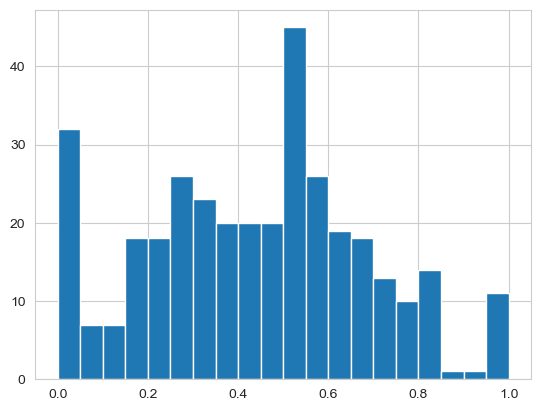

In [15]:
vafs = []
for i in range(100):
    gts = agt[:,i]
    alts = aalt[:,i]
    refs = aref[:,i]
    
    # print(list(np.unique(gts)))
    if "R" in list(np.unique(gts)) and "H" in list(np.unique(gts)):
        ind = np.where(gts == "H")
        vafs.extend(list(alts[ind]/(alts[ind]+refs[ind])))
        # print("ok")
        
        
plt.hist(vafs, bins=20)
plt.show()

In [6]:
N = 300                 # Read depth
num_simulations = len(N_nonzero) # Number of simulations

plt.figure(figsize=(12, 8))
indices = np.where(np.array(genotypes) == "H")[0]
plt.hist((k_obs_nonzero/N_nonzero)[indices], bins=50)
plt.title("Observed VAF for Heterozygous Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xlim([0, 1])
plt.grid(False)
plt.show()

# dropout_prob, dropout_direction_prob, alpha_h, beta_h, error_rate, overdispersion  = 0.01, 0.5, 3, 3, 0.1, 0.18
vaf_counts = simulate_vaf_counts(alpha_h, beta_h, dropout_prob, dropout_direction_prob, N, num_simulations, error_rate, overdispersion)

plt.figure(figsize=(12, 8))
plt.hist(vaf_counts, bins=50)
plt.title("Updated Prior VAF for Heterozygous Genotype with Dropout",  fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.xlim([0, 1])
plt.ylabel("Frequency", fontsize=20)
plt.grid(False)

plt.show()

plt.figure(figsize=(12, 8))
indices = np.where(np.array(genotypes) == "A")[0]
plt.hist((k_obs_nonzero/N_nonzero)[indices], bins=50)
plt.title("Observed VAF for Homozygous Alternative Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.grid(False)
plt.show()

alpha = (1-error_rate) * overdispersion
beta = overdispersion - alpha

# Generate simulated data for VAF using Beta-Binomial
simulated_vaf = betabinom.rvs(N, alpha, beta, size=len(indices)) / N  # Scale by N to get VAFs

plt.figure(figsize=(12, 8))
plt.hist(simulated_vaf, bins=50)
plt.title("Updated Prior VAF for Homozygous Alternative Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.grid(False)
plt.show()

NameError: name 'N_nonzero' is not defined

In [1]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import yaml

from src_python.data_generator import DataGenerator
from src_python.mutation_tree import MutationTree
from src_python.noise_mutation_filter import MutationFilter
from src_python.swap_optimizer import SwapOptimizer

with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

seed = config["random_seed"]
np.random.seed(seed)

import numpy as np

def create_genotype_matrix(not_selected_genotypes, selected, gt1, gt2, mutation_matrix, flipped):
    n_cells = mutation_matrix.shape[0]
    n_loci = len(selected) + len(not_selected_genotypes)
    genotype_matrix = np.full((n_cells, n_loci), "", dtype="str")

    not_selected = [i for i in range(n_loci) if i not in selected]

    # Assign genotypes for loci not selected for tree learning
    for n, locus in enumerate(not_selected):
        genotype_matrix[:, locus] = not_selected_genotypes[n]

    # Assign genotypes for loci selected for tree learning
    for n, locus in enumerate(selected):
        if flipped[n]:
            genotype_matrix[:, locus] = np.where(
                mutation_matrix[:, n] == 0, gt2[n],
                np.where(mutation_matrix[:, n] == 1, gt1[n], mutation_matrix[:, n])
            )
        else:
            genotype_matrix[:, locus] = np.where(
                mutation_matrix[:, n] == 0, gt1[n],
                np.where(mutation_matrix[:, n] == 1, gt2[n], mutation_matrix[:, n])
            )

    return genotype_matrix

def create_mutation_matrix(parent_vector, mutation_indices, ct):
    n_cells = len(parent_vector)
    n_leaves = int((n_cells+1)/2)
    n_mutations = len(mutation_indices)

    # Initialize mutation matrix with zeros
    mutation_matrix = np.zeros((n_cells, n_mutations), dtype=int)

    # Mark cells with mutations
    for mutation_idx, cell_idx in enumerate(mutation_indices):
        children = [c for c in ct.dfs(cell_idx)]
        for cell in children:  # Traverse all cells below the mutation cell
            mutation_matrix[cell, mutation_idx] = 1  # Mark cells with the mutation

    return mutation_matrix[:n_leaves]

path = r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data\100c50m"

optimizer = SwapOptimizer(spaces = ["c", "m"], reverse_mutations=True)
total_rounds = 5
n_samples = 10

error_rate = config["error_rate"]
overdispersion=config["overdispersion"]
genotype_freq=config["genotype_freq"] 
mut_freq=config["mut_freq"]
alpha_h=config["alpha_h"]
beta_h=config["beta_h"]
dropout_prob=config["dropout_prob"]
dropout_direction_prob=config["dropout_direction_prob"]
dropout_alpha = config["dropout_alpha"]
dropout_beta = config["dropout_beta"]
dropout_dir_alpha = config["dropout_dir_alpha"]
dropout_dir_beta = config["dropout_dir_beta"]

all_params = []
all_individual_params = []
all_individual_genotypes = []

for i in tqdm(range(n_samples)):
    
    all_params_i = []
    
    alt = np.loadtxt(os.path.join(path, "alt", 'alt_%i.txt' % i)).T
    ref = np.loadtxt(os.path.join(path, "ref", 'ref_%i.txt' % i)).T
    genotype_gt = np.loadtxt((os.path.join(path, "genotype", "genotype_%i.txt" % i)), dtype = str).T
    dropout_probs_gt = np.loadtxt((os.path.join(path, "dropout_probs", "dropout_probs_%i.txt" % i)))
    dropout_directions_gt = np.loadtxt((os.path.join(path, "dropout_directions", "dropout_directions_%i.txt" % i)))
    alphas_H_gt = np.loadtxt((os.path.join(path, "alphas_H", "alphas_H_%i.txt" % i)))
    betas_H_gt = np.loadtxt((os.path.join(path, "betas_H", "betas_H_%i.txt" % i)))
        
    total = ref + alt
    n_snvs = total.shape[1]
    individual_dropout_probs = np.ones(n_snvs, dtype=float) * dropout_alpha/(dropout_alpha+dropout_beta)
    individual_dropout_direction_probs = np.ones(n_snvs, dtype=float) * dropout_dir_alpha/(dropout_dir_alpha+dropout_dir_beta)
    individual_alphas_h = np.ones(n_snvs, dtype=float) * alpha_h
    individual_betas_h = np.ones(n_snvs, dtype=float) * beta_h
    
        
    for round in range(total_rounds):
        mf = MutationFilter(error_rate= error_rate, overdispersion=overdispersion,
                            genotype_freq=genotype_freq, mut_freq=mut_freq,
                            alpha_h=alpha_h, beta_h=beta_h, dropout_alpha=dropout_alpha, dropout_beta=dropout_beta, dropout_dir_alpha=dropout_dir_alpha, dropout_dir_beta=dropout_dir_beta)
        selected, gt1, gt2, not_selected_genotypes = mf.filter_mutations(ref, alt, method='first_k', n_exp=100, t=0.5) #  method='threshold', t=0.5,
        llh_1, llh_2 = mf.get_llh_mat(ref[:, selected], alt[:, selected], gt1, gt2, individual=True, dropout_probs=individual_dropout_probs, dropout_direction_probs=individual_dropout_direction_probs, alphas_H=individual_alphas_h, betas_H=individual_betas_h)
    
        optimizer.fit_llh(llh_1, llh_2)
        optimizer.optimize()
        mutation_matrix = create_mutation_matrix(optimizer.ct.parent_vec, optimizer.ct.mut_loc, optimizer.ct)
        flipped = optimizer.ct.flipped
        genotype = create_genotype_matrix(not_selected_genotypes, selected, gt1, gt2, mutation_matrix, flipped)

        vaf_error = np.sum(genotype != genotype_gt)
        print(vaf_error)
        all_individual_params.append([individual_dropout_probs, dropout_probs_gt, individual_dropout_direction_probs, dropout_directions_gt, individual_alphas_h, alphas_H_gt, individual_betas_h, betas_H_gt])
        all_individual_genotypes.append([genotype_gt, genotype])
        
        # the following part doesn't work, as it doesn't take into account the dropout direction
        # vafs_ah = []
        # vafs_rh = []
        # for j in range(100):
        #     gts = genotype[:,j]
        #     alts = alt[:,j]
        #     refs = ref[:,j]
        #     
        #     if "A" in list(np.unique(gts)) and "H" in list(np.unique(gts)):
        #         ind = np.where(gts == "H")
        #         vafs_ah.extend(list(alts[ind]/(alts[ind]+refs[ind])))
        #         
        #     if "R" in list(np.unique(gts)) and "H" in list(np.unique(gts)):
        #         ind = np.where(gts == "H")
        #         vafs_rh.extend(list(alts[ind]/(alts[ind]+refs[ind])))
           
        # low_count_ah = sum(v < 0.01 for v in vafs_ah)  
        # high_count_ah = sum(v > 0.99 for v in vafs_ah)
        # low_count_rh = sum(v < 0.01 for v in vafs_rh)  
        # high_count_rh = sum(v > 0.99 for v in vafs_rh)  
        # 
        # 
        # alt_f = list(alt.flatten())
        # ref_f = list(ref.flatten())
        # genotype_f = list(genotype.flatten())
        # 
        # while high_count_ah < low_count_ah:
        #     alt_f.append(np.mean(total).astype(int))
        #     ref_f.append(0)
        #     genotype_f.append("H")
        #     high_count_ah += 1
        # 
        # while low_count_rh < high_count_rh:
        #     alt_f.append(0)
        #     ref_f.append(np.mean(total).astype(int))
        #     genotype_f.append("H")
        #     low_count_rh += 1

        params = mf.update_parameters(np.array(ref), np.array(alt), np.array(genotype))
        
        # plt.figure(figsize=(12, 8))
        # indices = np.where(np.array(genotype_gt) == "H")
        # vaf = alt[indices]/(ref[indices]+alt[indices])
        # plt.hist(vaf, bins=20)
        # plt.title("Observed VAF for Heterozygous Genotype", fontsize=20)
        # plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
        # plt.ylabel("Frequency", fontsize=20)
        # plt.xlim([0, 1])
        # plt.grid(False)
        # plt.show()
        
        dropout_probs, dropout_direction_probs, overdispersions, error_rates, alpha_hs, beta_hs, individual_dropout_probs, individual_dropout_direction_probs, individual_alphas_h, individual_betas_h = params
        # individual_dropout_probs, individual_dropout_direction_probs, individual_alphas_h, individual_betas_h = dropout_probs_gt, dropout_directions_gt, alphas_H_gt, betas_H_gt
        all_params_i.append([dropout_probs, dropout_direction_probs, overdispersions, error_rates, alpha_hs, beta_hs, vaf_error])
        print(f"Round {round} ")
    all_params.append(all_params_i)

  0%|          | 0/10 [00:00<?, ?it/s]

Optimizing cell lineage tree ...
-3901.512481718836 -3895.3881012199236
Optimizing mutation tree ...
after Node reattachment  -3889.236239799895
-3885.4311427414327 -3885.4311427414327
Optimizing cell lineage tree ...
-3885.4311427414327 -3885.4311427414323
Optimizing mutation tree ...
after Node reattachment  -3884.0496754640603
-3883.195404703254 -3883.195404703254
Optimizing cell lineage tree ...
-3883.195404703254 -3883.195404703254
Optimizing mutation tree ...
after Node reattachment  -3883.195404703254
-3883.195404703254 -3883.195404703254
350
optimized:  3848.1720141746487
ground truth:  3886.0231037786557
Global parameters: [ 0.06789248  0.55461421 10.43330757  0.04481459  5.99569825]
Round 0 
Optimizing cell lineage tree ...
-3891.1483962947004 -3887.9689228559373
Optimizing mutation tree ...
after Node reattachment  -3882.6586597293617
-3878.5195254811356 -3878.519525481134
Optimizing cell lineage tree ...
-3877.212150359538 -3877.212150359537
Optimizing mutation tree ...
aft

 10%|█         | 1/10 [00:45<06:51, 45.67s/it]

Round 4 
Optimizing cell lineage tree ...
-4234.50575450112 -4232.959973807928
Optimizing mutation tree ...
after Node reattachment  -4230.9395437626235
-4227.891583125815 -4227.891583125815
Optimizing cell lineage tree ...
-4225.635176778386 -4225.635176778387
Optimizing mutation tree ...
after Node reattachment  -4224.660786415516
-4222.3759757105845 -4222.375975710585
Optimizing cell lineage tree ...
-4222.3759757105845 -4222.375975710585
Optimizing mutation tree ...
after Node reattachment  -4221.677906800706
-4221.661192702431 -4221.661192702431
Optimizing cell lineage tree ...
-4221.661192702431 -4221.661192702431
Optimizing mutation tree ...
after Node reattachment  -4221.535394371189
-4221.535394371189 -4221.535394371189
Optimizing cell lineage tree ...
-4221.535394371189 -4221.535394371189
Optimizing mutation tree ...
after Node reattachment  -4221.535394371189
-4221.535394371189 -4221.535394371189
419
optimized:  4207.777257369847
ground truth:  4224.363093446592
Global param

 20%|██        | 2/10 [01:31<06:06, 45.83s/it]

Round 4 
Optimizing cell lineage tree ...
-4606.020284921974 -4598.853412430395
Optimizing mutation tree ...
after Node reattachment  -4589.256188639925
-4582.643842622717 -4582.643842622718
Optimizing cell lineage tree ...
-4576.766401836018 -4576.766401836018
Optimizing mutation tree ...
after Node reattachment  -4575.0700355551035
-4573.921351897477 -4573.921351897477
Optimizing cell lineage tree ...
-4573.232743626384 -4571.949035854039
Optimizing mutation tree ...
after Node reattachment  -4569.926201672477
-4569.926201672476 -4569.926201672477
Optimizing cell lineage tree ...
-4569.894998806193 -4569.894998806195
Optimizing mutation tree ...
after Node reattachment  -4569.894998806195
-4569.72145754575 -4569.721457545751
Optimizing cell lineage tree ...
-4569.72145754575 -4569.721457545751
Optimizing mutation tree ...
after Node reattachment  -4569.721457545751
-4569.72145754575 -4569.721457545751
374
optimized:  4546.707793398539
ground truth:  4572.549156621144
Global parameter

 30%|███       | 3/10 [02:20<05:30, 47.26s/it]

Round 4 
Optimizing cell lineage tree ...
-4111.707686580485 -4104.858247422453
Optimizing mutation tree ...
after Node reattachment  -4098.821263268801
-4086.222566201079 -4086.2225662010783
Optimizing cell lineage tree ...
-4084.405367172193 -4084.405367172192
Optimizing mutation tree ...
after Node reattachment  -4080.3908697165584
-4077.8843764011363 -4077.8843764011353
Optimizing cell lineage tree ...
-4077.8843764011363 -4077.8843764011353
Optimizing mutation tree ...
after Node reattachment  -4077.8843764011353
-4077.8843764011363 -4077.8843764011353
352
optimized:  4057.584440641788
ground truth:  4080.7120754765374
Global parameters: [ 0.16088802  0.40157783 10.45790251  0.04378901  6.51396943]
Round 0 
Optimizing cell lineage tree ...
-4099.056514419487 -4092.7525242970996
Optimizing mutation tree ...
after Node reattachment  -4084.8640840262724
-4080.2471294043166 -4080.6877492193275
Optimizing cell lineage tree ...
-4073.480066928562 -4073.4800669285632
Optimizing mutation 

 40%|████      | 4/10 [03:04<04:35, 45.93s/it]

Round 4 
Optimizing cell lineage tree ...
-4323.404359272534 -4321.290734124443
Optimizing mutation tree ...
after Node reattachment  -4311.176745513749
-4307.248006936667 -4307.248006936667
Optimizing cell lineage tree ...
-4304.656548893335 -4304.656548893334
Optimizing mutation tree ...
after Node reattachment  -4304.656548893334
-4304.593788237068 -4304.593788237068
Optimizing cell lineage tree ...
-4304.4005073041735 -4304.400507304174
Optimizing mutation tree ...
after Node reattachment  -4304.36516109179
-4304.36516109179 -4304.36516109179
Optimizing cell lineage tree ...
-4304.36516109179 -4304.36516109179
Optimizing mutation tree ...
after Node reattachment  -4304.36516109179
-4304.36516109179 -4304.36516109179
424
optimized:  4269.3120597737325
ground truth:  4307.192860167187
Global parameters: [ 0.1028733   0.53894087 10.06204708  0.04474528  5.86428566]
Round 0 
Optimizing cell lineage tree ...
-4316.0469601334735 -4306.417669116601
Optimizing mutation tree ...
after Node 

 50%|█████     | 5/10 [03:55<03:58, 47.75s/it]

Round 4 
Optimizing cell lineage tree ...
-4249.122103526639 -4238.865623136372
Optimizing mutation tree ...
after Node reattachment  -4227.98393407477
-4222.363574186936 -4224.688511751051
Optimizing cell lineage tree ...
-4222.323952472123 -4222.323952472124
Optimizing mutation tree ...
after Node reattachment  -4222.323952472124
-4221.367963687319 -4221.36796368732
Optimizing cell lineage tree ...
-4221.367963687319 -4221.36796368732
Optimizing mutation tree ...
after Node reattachment  -4221.36796368732
-4221.367963687319 -4221.36796368732
379
optimized:  4179.727762143538
ground truth:  4224.195662762728
Global parameters: [ 0.08806475  0.34330709 10.51024339  0.04536645  6.60092019]
Round 0 
Optimizing cell lineage tree ...
-4245.542718819641 -4238.211295201163
Optimizing mutation tree ...
after Node reattachment  -4230.222171706092
-4222.849561386398 -4223.610493383558
Optimizing cell lineage tree ...
-4219.2805491798 -4219.280549179801
Optimizing mutation tree ...
after Node re

 60%|██████    | 6/10 [04:46<03:14, 48.72s/it]

Round 4 
Optimizing cell lineage tree ...
-4117.030043339856 -4113.998708711648
Optimizing mutation tree ...
after Node reattachment  -4097.888511377459
-4085.159555380688 -4085.5810477853015
Optimizing cell lineage tree ...
-4083.799062617815 -4083.799062617815
Optimizing mutation tree ...
after Node reattachment  -4082.6227537198947
-4079.6778049237123 -4079.677804923713
Optimizing cell lineage tree ...
-4078.6710793263974 -4078.671079326398
Optimizing mutation tree ...
after Node reattachment  -4078.671079326398
-4078.6710793263974 -4078.671079326398
Optimizing cell lineage tree ...
-4078.671079326398 -4078.671079326398
408
optimized:  4037.1237687251023
ground truth:  4081.498778401798
Global parameters: [ 0.06589575  0.7636719  10.45271074  0.0431746   5.33806046]
Round 0 
Optimizing cell lineage tree ...
-4080.1663585750525 -4077.9700910398556
Optimizing mutation tree ...
after Node reattachment  -4071.2363017427265
-4066.9722810000612 -4066.9722810000617
Optimizing cell lineage 

 70%|███████   | 7/10 [05:40<02:32, 50.71s/it]

Round 4 
Optimizing cell lineage tree ...
-4002.6351624258846 -4001.907007333451
Optimizing mutation tree ...
after Node reattachment  -3997.4844240205666
-3992.203535168044 -3992.2035351680443
Optimizing cell lineage tree ...
-3989.9950502501165 -3989.9950502501165
Optimizing mutation tree ...
after Node reattachment  -3989.953160812405
-3988.7204205688317 -3989.7671156887095
Optimizing cell lineage tree ...
-3988.7204205688317 -3988.720420568832
Optimizing mutation tree ...
after Node reattachment  -3988.720420568832
-3988.7204205688317 -3988.720420568832
342
optimized:  3967.219617249726
ground truth:  3991.5481196442274
Global parameters: [ 0.06872383  0.56423095 10.88902776  0.04701167  5.25796558]
Round 0 
Optimizing cell lineage tree ...
-3998.047830448419 -3996.470235339639
Optimizing mutation tree ...
after Node reattachment  -3992.304984446971
-3990.495922160265 -3990.495922160265
Optimizing cell lineage tree ...
-3989.0024010887755 -3988.646974772778
Optimizing mutation tree

 80%|████████  | 8/10 [06:17<01:32, 46.21s/it]

Round 4 
Optimizing cell lineage tree ...
-4604.196632202765 -4595.543930556066
Optimizing mutation tree ...
after Node reattachment  -4591.69833085942
-4589.101688196549 -4589.689126134187
Optimizing cell lineage tree ...
-4588.656124183326 -4588.656124183327
Optimizing mutation tree ...
after Node reattachment  -4588.474255050304
-4588.474255050304 -4588.474255050304
Optimizing cell lineage tree ...
-4588.474255050303 -4588.474255050304
Optimizing mutation tree ...
after Node reattachment  -4588.474255050304
-4588.474255050303 -4588.474255050304
394
optimized:  4552.420817534371
ground truth:  4591.301954125699
Global parameters: [ 0.11525354  0.55671689 10.41132259  0.04605057  6.56915057]
Round 0 
Optimizing cell lineage tree ...
-4600.76654096776 -4595.352683959898
Optimizing mutation tree ...
after Node reattachment  -4581.876085323536
-4575.794384177457 -4576.445510201081
Optimizing cell lineage tree ...
-4573.5154299301585 -4573.515429930158
Optimizing mutation tree ...
after N

 90%|█████████ | 9/10 [07:07<00:47, 47.40s/it]

Round 4 
Optimizing cell lineage tree ...
-3754.5340805900482 -3749.8900219108723
Optimizing mutation tree ...
after Node reattachment  -3747.310710014886
-3745.842600089516 -3745.842600089516
Optimizing cell lineage tree ...
-3744.5252410698326 -3744.1394358821626
Optimizing mutation tree ...
after Node reattachment  -3744.1394358821626
-3744.1394358821626 -3744.1394358821626
Optimizing cell lineage tree ...
-3744.1394358821626 -3744.1394358821626
Optimizing mutation tree ...
after Node reattachment  -3744.1394358821626
-3744.1394358821626 -3744.1394358821626
361
optimized:  3719.3980028351352
ground truth:  3746.967134957565
Global parameters: [0.15499177 0.61399472 9.70499778 0.04149004 6.23863118]
Round 0 
Optimizing cell lineage tree ...
-3756.708195465145 -3754.150744005268
Optimizing mutation tree ...
after Node reattachment  -3749.004169143145
-3738.88240661042 -3740.375191007899
Optimizing cell lineage tree ...
-3738.818795832209 -3738.8187958322096
Optimizing mutation tree ..

100%|██████████| 10/10 [07:44<00:00, 46.43s/it]

Round 4 


In [2]:
np.array(all_individual_genotypes)[:,0].shape

(50, 100, 50)

In [3]:
# for i in tqdm(range(n_samples)):
#     alt = np.loadtxt(os.path.join(path, "alt", 'alt_%i.txt' % i)).T
#     ref = np.loadtxt(os.path.join(path, "ref", 'ref_%i.txt' % i)).T
#     genotype_gt = np.loadtxt((os.path.join(path, "genotype", "genotype_%i.txt" % i)), dtype = str).T
#     alphas_H_gt = np.loadtxt((os.path.join(path, "alphas_H", "alphas_H_%i.txt" % i)))
#     betas_H_gt = np.loadtxt((os.path.join(path, "betas_H", "betas_H_%i.txt" % i)))
#     
#     for snv in range(alt.shape[1]): 
#         vaf = alt[:, snv]/(alt[:, snv]+ref[:, snv])
#         if "H" in list(np.unique(genotype_gt[:, snv])):
#             ind = np.where(genotype_gt[:, snv] == "H")
#             vaf = vaf[ind]
#             if len(vaf) > 50:
#                 plt.title(f"{alphas_H_gt[snv]} and {betas_H_gt[snv]}")
#                 plt.hist(vaf, bins=20)
#                 plt.show()

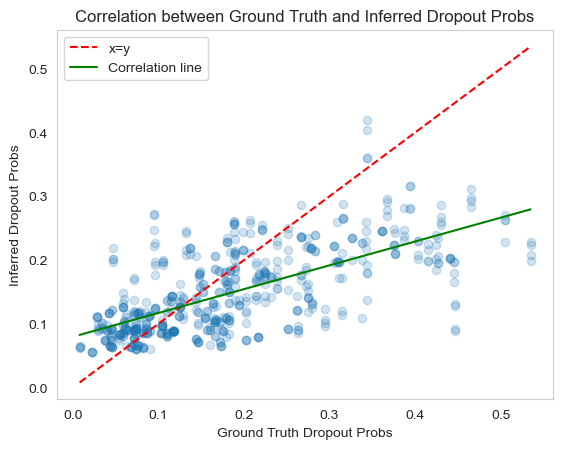

In [4]:
keep_indices = np.array([i for i in range(5*n_samples) if i % 5 != 0])
h_counts = np.sum(np.array(all_individual_genotypes)[keep_indices,0] == "H", axis=1)
mask = h_counts > 50
indices = mask.flatten()
x = np.array(all_individual_params)[keep_indices, 1].flatten()[indices] # gt
y = np.array(all_individual_params)[keep_indices, 0].flatten()[indices] # predicted

plt.scatter(x, y, alpha=0.2)
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Dropout Probs")
plt.ylabel("Inferred Dropout Probs")
plt.title("Correlation between Ground Truth and Inferred Dropout Probs")
plt.legend()
plt.show()

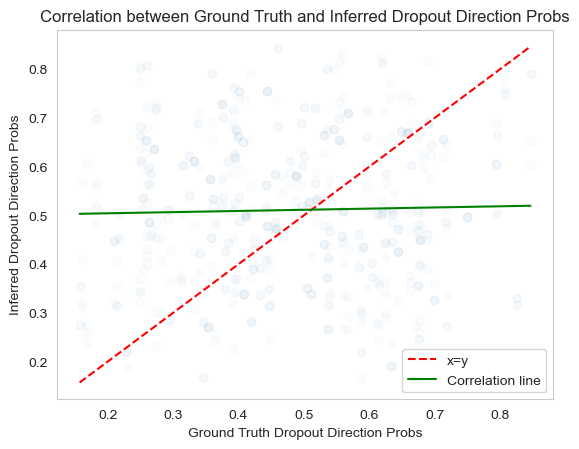

In [5]:
x = np.array(all_individual_params)[keep_indices, 3].flatten()[indices] # gt
y = np.array(all_individual_params)[keep_indices, 2].flatten()[indices] # predicted

plt.scatter(x, y, alpha=0.02)
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Dropout Direction Probs")
plt.ylabel("Inferred Dropout Direction Probs")
plt.title("Correlation between Ground Truth and Inferred Dropout Direction Probs")
plt.legend()
plt.show()

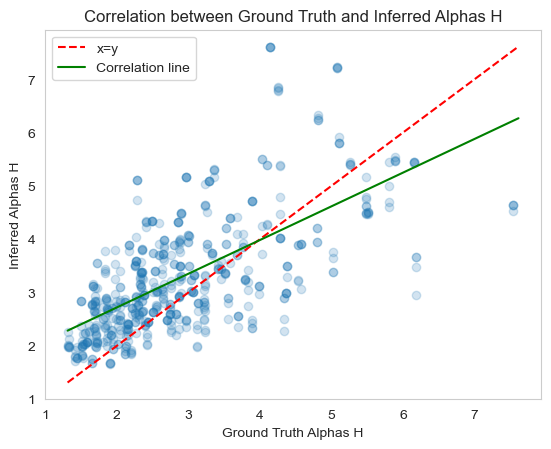

In [6]:
x_alpha = np.array(all_individual_params)[keep_indices, 5].flatten()[indices] # gt
y_alpha = np.array(all_individual_params)[keep_indices, 4].flatten()[indices] # predicted

plt.scatter(x_alpha, y_alpha, alpha=0.2)
lims = [min(x_alpha.min(), y_alpha.min()), max(x_alpha.max(), y_alpha.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x_alpha, y_alpha, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Alphas H")
plt.ylabel("Inferred Alphas H")
plt.title("Correlation between Ground Truth and Inferred Alphas H")
plt.legend()
plt.show()

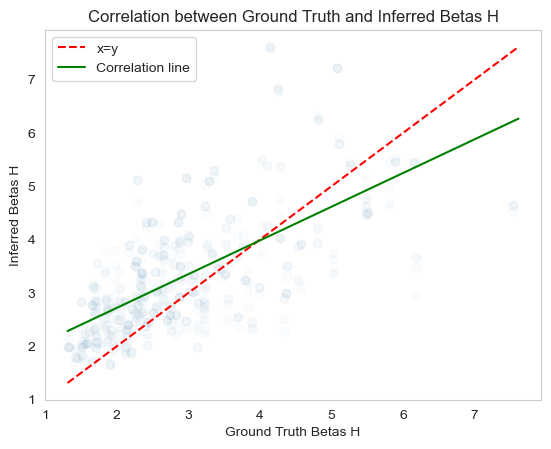

In [7]:
x_beta = np.array(all_individual_params)[keep_indices, 7].flatten()[indices] # gt
y_beta = np.array(all_individual_params)[keep_indices, 6].flatten()[indices] # predicted

plt.scatter(x_beta, y_beta, alpha=0.02)
lims = [min(x_beta.min(), y_beta.min()), max(x_beta.max(), y_beta.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x_beta, y_beta, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Betas H")
plt.ylabel("Inferred Betas H")
plt.title("Correlation between Ground Truth and Inferred Betas H")
plt.legend()
plt.show()

C:\Users\Norio\AppData\Local\Temp\ipykernel_31600\1137287141.py:8: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x, y, 1)


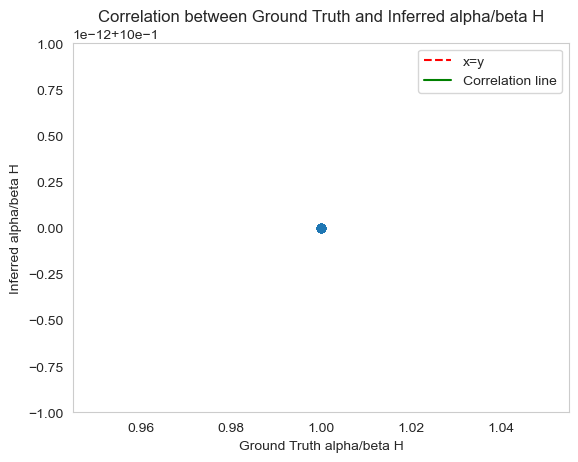

In [8]:
x = x_alpha/x_beta
y = y_alpha/y_beta # predicted

plt.scatter(x, y, alpha=0.02)
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth alpha/beta H")
plt.ylabel("Inferred alpha/beta H")
plt.title("Correlation between Ground Truth and Inferred alpha/beta H")
plt.legend()
plt.show()

In [12]:
def genotype_confusion_matrix(genotype, genotype_gt):
    unique_genotypes = ["R", "H", "A"]
    confusion_counts = {g: {other: 0 for other in unique_genotypes} for g in unique_genotypes}

    for true, pred in zip(genotype_gt.flatten(), genotype.flatten()):
        if true != pred:
            confusion_counts[true][pred] += 1  # Count how often true genotype is mistaken for pred

    # Print results
    print("Replacements:")
    for true, counts in confusion_counts.items():
        for pred, count in counts.items():
            if true != pred:  # Only show misclassifications
                print(f"{true} → {pred}: {count}")

genotype_confusion_matrix(genotype_gt, genotype)

Replacements:
R → H: 217
R → A: 383
H → R: 278
H → A: 112
A → R: 769
A → H: 971


In [11]:
i=2
path = r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data\500c50m"

alt = np.loadtxt(os.path.join(path, "alt", 'alt_%i.txt' % i)).T
ref = np.loadtxt(os.path.join(path, "ref", 'ref_%i.txt' % i)).T
genotype_gt = np.loadtxt((os.path.join(path, "genotype", "genotype_%i.txt" % i)), dtype = str).T
dropout_probs_gt = np.loadtxt((os.path.join(path, "dropout_probs", "dropout_probs_%i.txt" % i)))
dropout_directions_gt = np.loadtxt((os.path.join(path, "dropout_directions", "dropout_directions_%i.txt" % i)))
alphas_H_gt = np.loadtxt((os.path.join(path, "alphas_H", "alphas_H_%i.txt" % i)))
betas_H_gt = np.loadtxt((os.path.join(path, "betas_H", "betas_H_%i.txt" % i)))
params = mf.update_parameters(np.array(ref), np.array(alt), np.array(genotype_gt))
dropout_probs, dropout_direction_probs, overdispersions, error_rates, alpha_hs, beta_hs, individual_dropout_probs, individual_dropout_direction_probs, individual_alphas_h, individual_betas_h = params

optimized:  23226.52048298504
ground truth:  23242.62323439122
Global parameters: [ 0.22689196  0.46977098 10.10182335  0.05121476  5.33750334]


IndexError: list index out of range

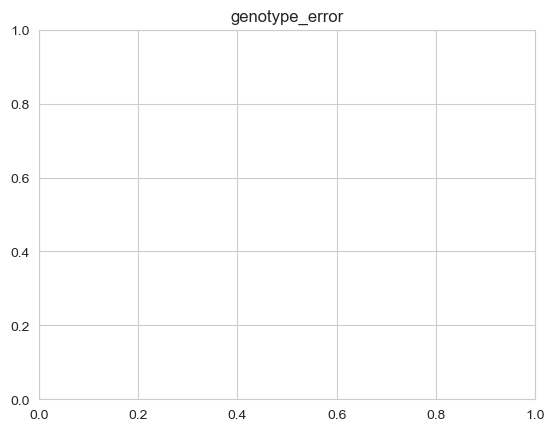

In [15]:
param = ["dropout_probs", "dropout_direction_probs", "overdispersions", "error_rates", "alpha_hs", "beta_hs", "genotype_error"]
for i in [6]: #range(len(np.mean(all_params, axis=0)[0])):
    plt.title(param[i])
    plt.plot(np.mean(np.array(all_params), axis=0)[:,i])
    plt.show()

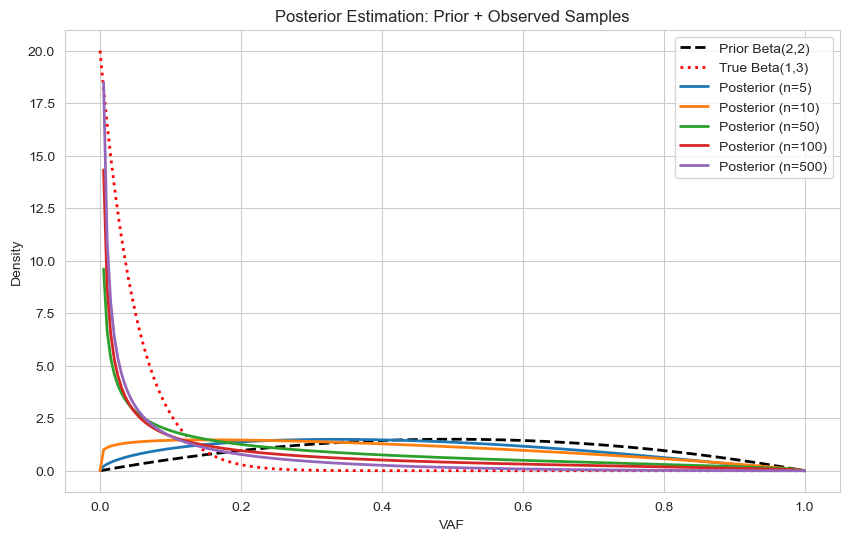

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Define the distributions
true_alpha, true_beta = 1.5, 6     # True data-generating distribution: Beta(1,3)
prior_alpha, prior_beta = 2, 2   # Prior distribution: Beta(2,2)

# Effective sample size from the prior: alpha+beta (here, 4 pseudo-samples)
prior_eff = int(prior_alpha + prior_beta)*10

# Draw pseudo-samples from the prior to represent prior knowledge
np.random.seed(42)
prior_samples = np.random.beta(prior_alpha, prior_beta, size=prior_eff)

# Define various observed sample sizes from the true distribution
sample_sizes = [5, 10, 50, 100, 500]
x = np.linspace(0, 1, 200)

plt.figure(figsize=(10, 6))

# Plot the prior and true distributions for reference
plt.plot(x, beta.pdf(x, prior_alpha, prior_beta), 'k--', lw=2, label="Prior Beta(2,2)")
plt.plot(x, beta.pdf(x, true_alpha, true_beta), 'r:', lw=2, label="True Beta(1,3)")

# For each observed sample size, combine observed data with prior pseudo-samples,
# then compute method-of-moments estimates.
for n in sample_sizes:
    # Sample n VAFs from the true distribution Beta(1,3)
    observed_samples = np.random.beta(true_alpha, true_beta, size=n)
    
    # Combine prior pseudo-samples with observed samples
    combined_samples = np.concatenate([prior_samples, observed_samples])
    
    # Calculate the combined sample mean and variance (ddof=1 for unbiased variance)
    sample_mean = np.mean(combined_samples)
    sample_var = np.var(combined_samples, ddof=1)
    
    # To avoid division by zero for extremely small variance
    if sample_var == 0:
        continue

    # Method-of-moments estimation for Beta parameters:
    # common_term = sample_mean*(1-sample_mean)/sample_var - 1
    common_term = sample_mean * (1 - sample_mean) / sample_var - 1
    est_alpha = sample_mean * common_term
    est_beta = (1 - sample_mean) * common_term
    
    # Get the estimated PDF
    pdf_est = beta.pdf(x, est_alpha, est_beta)
    plt.plot(x, pdf_est, lw=2, label=f'Posterior (n={n})')

plt.xlabel("VAF")
plt.ylabel("Density")
plt.title("Posterior Estimation: Prior + Observed Samples")
plt.legend()
plt.show()

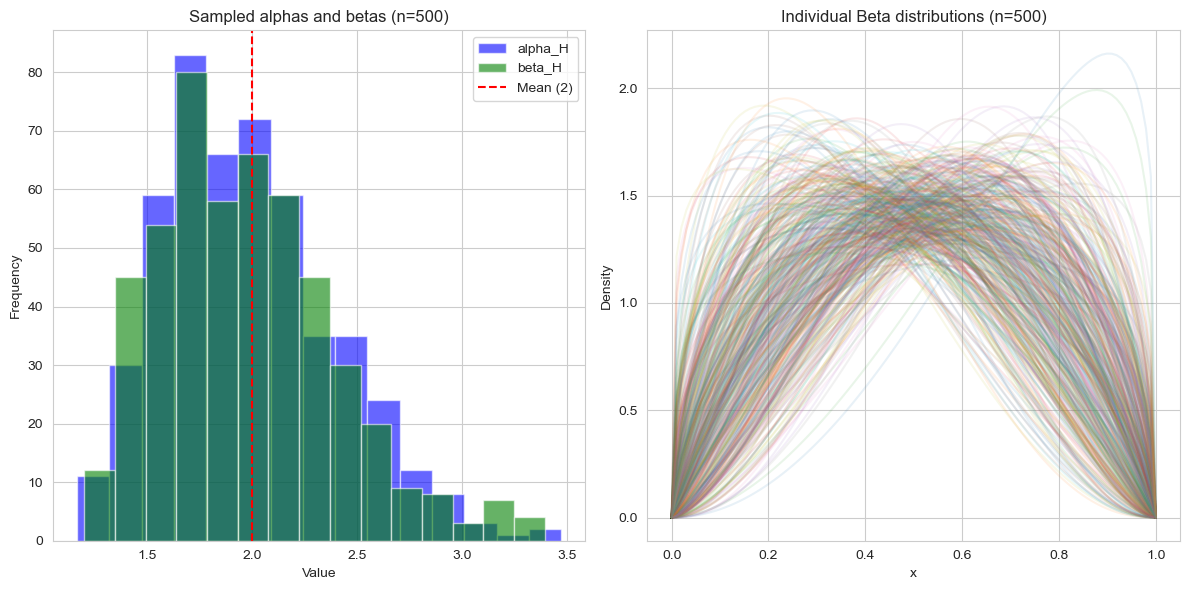

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, beta

# Parameters for alpha_H and beta_H distributions
shape = 5
shift = 1
mean_alpha = mean_beta = 2

# Scale derived to make mean correct
scale = (mean_alpha - shift) / shape

# Sample from shifted gamma (alpha_H and beta_H)
n_samples = 500  # reduced to make individual plots readable
alphas = gamma.rvs(shape, loc=shift, scale=scale, size=n_samples)
betas = gamma.rvs(shape, loc=shift, scale=scale, size=n_samples)

# Plotting setup
x = np.linspace(0, 1, 100)  # Beta distribution is defined on [0, 1]

plt.figure(figsize=(12, 6))

# Plot the alphas and betas histograms (left plot)
plt.subplot(1, 2, 1)
plt.hist(alphas, bins=15, alpha=0.6, color='blue', label='alpha_H')
plt.hist(betas, bins=15, alpha=0.6, color='green', label='beta_H')
plt.axvline(mean_alpha, color='red', linestyle='--', label='Mean (2)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Sampled alphas and betas (n={n_samples})')
plt.grid(True)

# Plot individual Beta distributions (right plot)
plt.subplot(1, 2, 2)
for i in range(n_samples):
    plt.plot(x, beta.pdf(x, alphas[i], betas[i]), alpha=0.1)

plt.xlabel('x')
plt.ylabel('Density')
plt.title(f'Individual Beta distributions (n={n_samples})')
plt.grid(True)

plt.tight_layout()
plt.show()

In [7]:
import numpy as np
from scipy.stats import beta, lognorm, gamma

class Model:
    def __init__(self, alpha_H, beta_H):
        self.alpha_H = alpha_H
        self.beta_H = beta_H

    def compute_log_prior(self, dropout_prob, dropout_direction_prob, overdispersion, error_rate, alpha_h, beta_h):
        sigma_od = 1
        scale_od = 10 * np.exp(sigma_od**2)
        shape = 2
        shift = 1
        scale_alpha = (self.alpha_H - shift) / (shape-1)
        scale_beta = (self.beta_H - shift) / (shape-1)
        print(scale_alpha, scale_beta, self.alpha_H, self.beta_H)
        
        # Compute the log-prior values for each parameter
        log_prior = (
            beta.logpdf(dropout_prob, 3, 9) + # max at 0.2
            beta.logpdf(dropout_direction_prob, 2, 2) +
            lognorm.logpdf(overdispersion, s=sigma_od, scale=scale_od) +
            beta.logpdf(error_rate, 1.5, 12) + # max at 0.05
            gamma.logpdf(alpha_h, shape, loc=shift, scale=1) +
            gamma.logpdf(beta_h, shape, loc=shift, scale=1)  # Uncomment for gamma priors
        )
        return log_prior

# Example initialization
alpha_H = 2  # Change as needed
beta_H = 2   # Change as needed
model = Model(alpha_H, beta_H)

# Test parameters
param_sets = [
    {"dropout_prob": 0.01, "dropout_direction_prob": 0.99, "overdispersion": 10, "error_rate": 0.001, "alpha_h": 1.1, "beta_h": 12},
    {"dropout_prob": 0.2, "dropout_direction_prob": 0.5, "overdispersion": 10, "error_rate": 0.05, "alpha_h": 1.5, "beta_h": 2},
    {"dropout_prob": 0.2, "dropout_direction_prob": 0.3, "overdispersion": 15, "error_rate": 0.1, "alpha_h": 12, "beta_h": 18},
    {"dropout_prob": 0.4, "dropout_direction_prob": 0.7, "overdispersion": 8, "error_rate": 0.02, "alpha_h": 8, "beta_h": 10}
]

# Print the log-prior for different parameter sets
for params in param_sets:
    log_prior = model.compute_log_prior(**params)
    print(f"Log Prior for params {params} = {log_prior}")

1.0 1.0 2 2
Log Prior for params {'dropout_prob': 0.01, 'dropout_direction_prob': 0.99, 'overdispersion': 10, 'error_rate': 0.001, 'alpha_h': 1.1, 'beta_h': 12} = -20.222192390397858
1.0 1.0 2 2
Log Prior for params {'dropout_prob': 0.2, 'dropout_direction_prob': 0.5, 'overdispersion': 10, 'error_rate': 0.05, 'alpha_h': 1.5, 'beta_h': 2} = -2.492213998497678
1.0 1.0 2 2
Log Prior for params {'dropout_prob': 0.2, 'dropout_direction_prob': 0.3, 'overdispersion': 15, 'error_rate': 0.1, 'alpha_h': 12, 'beta_h': 18} = -23.572678408867567
1.0 1.0 2 2
Log Prior for params {'dropout_prob': 0.4, 'dropout_direction_prob': 0.7, 'overdispersion': 8, 'error_rate': 0.02, 'alpha_h': 8, 'beta_h': 10} = -13.386493127598628
